# Сжатие языковой модели

## Порядок сдачи домашнего

Под каждое домашнее вы создаете отдельную ветку куда вносите все изменения в рамках домашнего. Как только домашнее готово - создаете пулл реквест (обратите внимание что в пулл реквесте должны быть отражены все изменения в рамках домашнего). Ревьювера назначаете из таблицы - https://docs.google.com/spreadsheets/d/1vK6IgEqaqXniUJAQOOspiL_tx3EYTSXW1cUrMHAZFr8/edit?gid=0#gid=0
Перед сдачей проверьте код, напишите тесты. Не забудьте про PEP8, например, с помощью flake8. Задание нужно делать в jupyter notebook.

**Дедлайн - 17 октбяря 10:00**

В этом домашнем задании вам предстоит изучить и реализовать комбинированный алгоритм для сжатия матриц весов языковой модели, который включает три этапа: 
- **Квантизацию**
- **Кодирование Хаффмана**
- **Бит-паккинг**
- **Запись и чтение в файл**

Вам также необходимо будет реализовать обратную процедуру расжатия для восстановления матрицы до её исходного состояния. Пакетом `numpy` пользовать нельзя.

Для начала сгенерируем нашу матрицу весов. Реализуйте функцию `generate_normal_weights_matrix`, которая будет генерировать матрицу случайных весов, где веса распределены нормально. Вам понадобится функция `random.gauss` для генерации случайных чисел из нормального распределения:

In [552]:
import random
mean = 0.0
stddev = 0.1
random.gauss(mean, stddev)

-0.0737434723244693

```python
weights_matrix = generate_normal_weights_matrix(5, 5)
for row in weights_matrix:
    print(row)
[0.3000485326712691, 0.25965299191334695, -0.06755153631842248, 0.13020487844655038, 0.1143769419370928]
[0.04287032494033407, 0.37860865986969466, -0.21154587156719093, 0.02538857794887883, 0.358874552698265]
[-0.12730102686770312, -0.09250783210681686, -0.31943991155969786, -0.12649930568136855, -0.133368865014227]
[-0.001125940850390421, 0.08131363950833258, -0.12099869191945688, 0.14554258117597563, 0.157276907472140]
[-0.07352639207896368, 0.013629438616873364, -0.11502982664385775, 0.042140678513802377, 0.0980238501942050]
```

In [553]:
def generate_normal_weights_matrix(rows, cols, mean=0.0, stddev=0.1):
    return [[random.gauss(mean, stddev) for _ in range(cols)] for _ in range(rows)]

weights_matrix = generate_normal_weights_matrix(2, 3)
for row in weights_matrix:
    print(row)

[0.013031395484107906, -0.053612084026118126, -0.16027423664834334]
[0.04234001302952407, 0.04775751206316055, -0.19622249127095473]


Для упрощения работы переведем двух мерный массив в одномерный.

In [554]:
weights_matrix = generate_normal_weights_matrix(100, 100, mean, stddev)

In [555]:
weights = [weight for row in weights_matrix for weight in row]
print(weights[:5])

[-0.00842325299874329, 0.012236194434508095, -0.035420266310360486, 0.01243449222878006, -0.07051665689128801]


Проверим, что у нас получилось.

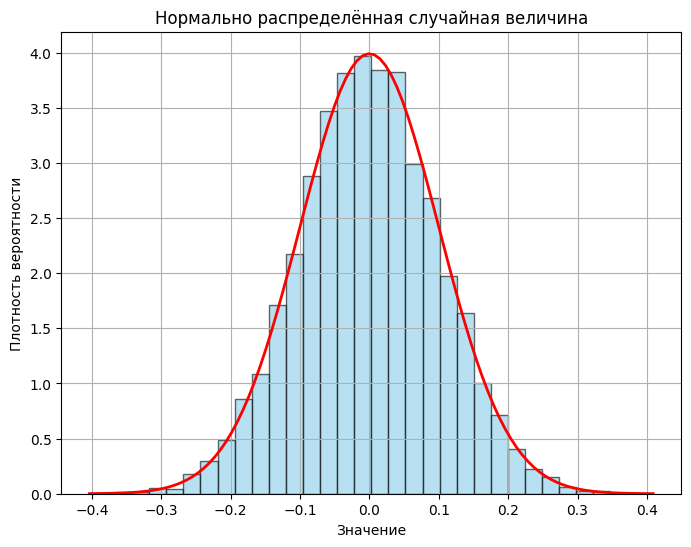

In [556]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(weights, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Добавление кривой плотности вероятности
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, stddev)  # Вычисление плотности вероятности
plt.plot(x, p, 'r', linewidth=2)

# Настройки графика
plt.title("Нормально распределённая случайная величина")
plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.grid(True)

# Отображение графика
plt.show()

Приступим к сжатию этой матрицы!

## Квантизация

**Квантизация** — это процесс преобразования данных с высокой точностью (например, с 32-битного представления) в данные с более низкой точностью (например, 8-битное представление) для уменьшения объёма памяти и вычислительных ресурсов. В контексте машинного обучения, квантизация чаще всего применяется к весам нейронных сетей и их активациям для уменьшения размера модели и ускорения работы, особенно при выполнении инференса на мобильных устройствах и встраиваемых системах.


### Цели квантизации:

1.	**Уменьшение объёма памяти:** Квантизация позволяет сократить объём памяти, занимаемый весами и другими параметрами модели, путём представления чисел с меньшей разрядностью.
2.	**Ускорение вычислений:** С помощью квантизации можно использовать специальные процессоры и ускорители (например, процессоры с поддержкой 8-битных вычислений), что увеличивает производительность.
3.	**Снижение энергопотребления:** Более короткие представления данных позволяют сократить энергопотребление при выполнении операций.

### Как работает квантизация?

Квантизация заключается в преобразовании значений с высокой точностью (например, числа с плавающей точкой) в числа с меньшей точностью (например, целые числа). Существует несколько методов квантизации:

1.	**Униформная (равномерная) квантизация:** Простая и часто используемая техника, когда диапазон значений разделяется на равные интервалы (кванты), и каждое значение округляется до ближайшего значения из этого интервала.
2.	**Неравномерная квантизация:** Применяется, когда диапазон значений распределён неравномерно, и поэтому используются интервалы с разной шириной.
3.	**Квантизация во время обучения (quantization-aware training):** Модель обучается с учётом того, что её веса будут квантизированы. Это позволяет лучше подготовить модель к работе в условиях низкой точности.
4.	**Квантизация после обучения (post-training quantization):** Модель сначала обучается с полной точностью, а затем веса и активации квантизируются.

В данном домашнем задании мы рассмотри наиболее простой вариант - **равномерная квантизация**.

### Пример униформной квантизации

Предположим, у нас есть матрица весов, представленная в виде чисел с плавающей точкой, и мы хотим сократить количество бит, используемых для хранения этих значений.

#### Шаг 1: Определение диапазона значений

Для начала определим минимальное и максимальное значение весов, чтобы определить диапазон:

In [557]:
min_value = min(weights)
max_value = max(weights)

print(f"Минимальное значение: {min_value}")
print(f"Максимальное значение: {max_value}")

Минимальное значение: -0.36653886948398384
Максимальное значение: 0.37200121416487475


#### Шаг 2: Определение шага квантизации

Теперь мы определим шаг квантизации, который будет разделять диапазон на равные интервалы. Предположим, что мы хотим использовать 8-битное представление. Это даёт нам $256$ различных значений (так как $8$ бит позволяют хранить $2^8 = 256$ различных чисел).

Шаг квантизации можно вычислить как:


$$\text{step} = \frac{\max - \min}{2^8 - 1}$$


In [558]:
num_levels = 256  # Для 8 бит
step = (max_value - min_value) / (num_levels - 1)
print(f"Шаг квантизации: {step}")

Шаг квантизации: 0.0028962356221523865


#### Шаг 3: Применение квантизации

Теперь мы можем преобразовать каждое значение в его ближайший квантизированный уровень:


$$\text{quantizedvalue} = \text{round} \left( \frac{\text{value} - \min}{\text{step}} \right)$$


In [559]:
quantized_weights = [round((weight - min_value) / step) for weight in weights]

print("Квантизированные веса:")
print(quantized_weights[:5])

Квантизированные веса:
[124, 131, 114, 131, 102]


#### Шаг 4: Обратное преобразование (деквантизация)

Чтобы восстановить оригинальные значения весов, необходимо преобразовать квантизированные значения обратно в их исходный диапазон:


$$\text{recovered_value} = \text{quantized_value} \times \text{step} + \min$$


In [560]:
recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]

print("Восстановленные веса:")
print(recovered_weights[:5])

Восстановленные веса:
[-0.007405652337087898, 0.012867997017978805, -0.036368008558611775, 0.012867997017978805, -0.07112283602444042]


Посчитаем максимальную ошибку

In [561]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.0014480452425282364

На практике намного удобнее, когда мы можем контролировать ошибку, поэтому реализуйте методы квантизации и деквантизации, у которых будет параметр максимальной возможной ошибки между значениями для задания `step`.

In [638]:
def quantize_weights(weights, max_error):
    max_value, min_value = max(weights), min(weights)
    bit_value = 1
    num_levels = 2**bit_value
    step = (max_value - min_value) / (num_levels - 1)

    quantized_weights = [round((weight - min_value) / step) for weight in weights]
    recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]
    
    error = max(abs(w-rw) for w, rw in zip(weights, recovered_weights))
    while error > max_error:
        bit_value += 1
        num_levels = 2**num_levels
        step = (max_value - min_value) / (num_levels - 1)
        quantized_weights = [round((weight - min_value) / step) for weight in weights]
        recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]
        error = max(abs(w-rw) for w, rw in zip(weights, recovered_weights))
    return quantized_weights, step, min_value

def dequantize_weights(quantized_weights, step, min_value):
    return [qw*step + min_value for qw in quantized_weights]

In [639]:
max_error = 0.01
quantized_weights, step, min_value = quantize_weights(weights, max_error)
recovered_weights = dequantize_weights(quantized_weights, step, min_value)

In [636]:
# test 1

w = [weight for row in generate_normal_weights_matrix(5, 5, mean, stddev) for weight in row]
quantized_w, step, min_value = quantize_weights(w, max_error)
recovered_w = dequantize_weights(quantized_w, step, min_value)
print(recovered_w[:5])
print(w[:5])

[0.04537187940225934, 0.0030414260365234924, -0.06552908024623187, -0.04445306974328181, 0.12717786837635933]
[0.04537109635444315, 0.003041446335674252, -0.06553094602315727, -0.04445480153133999, 0.12717860295476344]


In [637]:
# test 2

w = [weight for row in generate_normal_weights_matrix(5, 5, mean, stddev) for weight in row]
quantized_w, step, min_value = quantize_weights(w, max_error)
recovered_w = dequantize_weights(quantized_w, step, min_value)
print(recovered_w[:5])
print(w[:5])

[-0.034872891561494715, 0.08389445440051847, -0.011428303550233956, -0.024289913387945034, 0.09701430916016786]
[-0.03487470652932007, 0.08389510897549607, -0.01142682815114338, -0.024288780344688322, 0.09701295711216142]


## Кодирование Хаффмана

**Кодирование Хаффмана** — это алгоритм сжатия данных, который используется для минимизации количества бит, необходимых для представления данных. Алгоритм Хаффмана является типом префиксного кодирования, где каждому символу данных назначается уникальная двоичная строка (код), и никакой код не является префиксом другого кода.

Этот метод особенно полезен, когда некоторые символы встречаются чаще других. Хаффмановское кодирование назначает более короткие коды для часто встречающихся символов и более длинные коды для редких символов, что позволяет сжимать данные без потерь.

Основные характеристики кодирования Хаффмана:

- **Префиксный код:** никакой код не является префиксом другого кода, что позволяет однозначно декодировать последовательность.
- **Оптимальность:** алгоритм Хаффмана даёт минимальную длину кодов для символов при известной частоте их появления.
- **Дерево Хаффмана:** строится на основе частот символов, где часто встречающиеся символы находятся ближе к корню дерева.


### Этапы работы алгоритма Хаффмана:

1.	**Подсчёт частот:** На первом шаге подсчитывается, как часто каждый символ встречается в данных.
2.	**Построение дерева Хаффмана:** Используя частоты символов, строится бинарное дерево. Символы с меньшими частотами располагаются дальше от корня дерева, а символы с более высокими частотами — ближе.
3.	**Назначение кодов:** Проходя от корня дерева к каждому листу (символу), алгоритм назначает каждому символу код: левой ветви присваивается “0”, а правой ветви — “1”. Таким образом, для каждого символа формируется уникальная двоичная строка.
4.	**Сжатие данных:** После того как к каждому символу присвоен код, данные можно сжать, заменив символы на соответствующие двоичные коды.
5.	**Декодирование:** Для восстановления исходных данных декодирование выполняется путём чтения двоичной строки и перемещения по дереву Хаффмана от корня до символа, который закодирован.

### Пример работы алгоритма Хаффмана

Рассмотрим, как кодирование Хаффмана может быть применено к строке “ABRACADABRA”.

**1.	Частоты символов:**
Подсчитаем частоты каждого символа в строке:
```python
A: 5
B: 2
R: 2
C: 1
D: 1
```

**2. Построение дерева Хаффмана:**
- Начнем с того, что каждый символ представляется в виде узла дерева с весом, равным частоте появления символа.
- На каждом шаге выбираются два узла с наименьшими частотами и объединяются в новый узел, вес которого равен сумме частот двух выбранных узлов. Этот процесс повторяется до тех пор, пока не будет построено одно дерево.

Строим дерево Хаффмана:
```python
Шаг 1:   C:1  D:1 -> 2 (левое поддерево: C, правое поддерево: D)
Шаг 2:   B:2  R:2 -> 4 (левое поддерево: B, правое поддерево: R)
Шаг 3:   2 (CD)  4 (BR) -> 6
Шаг 4:   A:5  6 (CD, BR) -> 11
```

Окончательное дерево Хаффмана выглядит следующим образом:

```python
      11
     /  \
    A(0)    6(1)
        /         \
      CD(0)         BR(1)
      /    \        /   \
     C(0)  D(1)     B(0)   R(1)
```

**3.	Назначение кодов:**
Теперь присвоим каждому символу код, начиная от корня дерева:
- A: 0
- C: 100
- D: 101
- B: 110
- R: 111

**4. Сжатие строки:**
Используя полученные коды, мы можем закодировать строку “ABRACADABRA”:
```python
A -> 0
B -> 110
R -> 111
A -> 0
C -> 100
A -> 0
D -> 101
A -> 0
B -> 110
R -> 111
A -> 0
```

Закодированная строка: 01101110100010101101110

Реализуйте методы `huffman_encode` и `huffman_decode` для кодирования и декодирования с помощью алгоритма Хаффмана.

In [641]:
def huffman_encode(weights):
    counter_dict = dict()
    for char in weights:
        counter_dict[str(char)] = counter_dict.get(str(char), 0) + 1
    sorted_counter_dict = sorted([(item, counter_dict[item]) for item in counter_dict], key = lambda pair: pair[1])
    pre_numbers = {char:"" for char in counter_dict}
    while len(sorted_counter_dict) != 1:
        el_1 = sorted_counter_dict.pop(0)
        el_2 = sorted_counter_dict.pop(0)
        for ch in el_1[0]:
            pre_numbers[ch] += str(0)
        for ch in el_2[0]:
            pre_numbers[ch] += str(1)

        sorted_counter_dict.append((f"{el_1[0]}{el_2[0]}", el_1[1] + el_2[1]))
        sorted_counter_dict = sorted(sorted_counter_dict, key=lambda pair: pair[1])

    huff_dict = {k: v[::-1] for k, v in pre_numbers.items()}
    encoded_data = "".join([huff_dict[char] for char in weights])
    return encoded_data, huff_dict

def huffman_decode(encoded_data, huff_dict):
    decoded_data = ""
    possible_char = ""
    invert_huff_dict = {v:k for k, v in huff_dict.items()}
    decoded_data_list = []
    for bit in encoded_data:
        possible_char += bit
        if possible_char in invert_huff_dict:
            decoded_data += invert_huff_dict[possible_char]
            decoded_data_list.append(invert_huff_dict[possible_char])
            possible_char = ""
    return decoded_data_list  # возвращаем список тк дальше придется иметь дело с числами 

data = "ABRACADABRA"
encoded_data, huff_dict = huffman_encode(data)
print(f"Закодированные данные: {encoded_data}")
# Закодированные данные: 01101001110011110110100

decoded_data = huffman_decode(encoded_data, huff_dict)
print(f"Декодированные данные: {''.join(decoded_data)}")
# Декодированные данные: ABRACADABRA

Закодированные данные: 01101110100010101101110
Декодированные данные: ABRACADABRA


In [643]:
# test 1

data = "testone"
encoded_data, huff_dict = huffman_encode(data)
decoded_data = huffman_decode(encoded_data, huff_dict)
print(f"Закодированные данные: {encoded_data}")
print(f"Декодированные данные: {''.join(decoded_data)}")
# Закодированные данные: 0110110011110010
# Декодированные данные: testone

Закодированные данные: 0110110011110010
Декодированные данные: testone


In [645]:
# test 2

data = "hellofromtest2"
encoded_data, huff_dict = huffman_encode(data)
decoded_data = huffman_decode(encoded_data, huff_dict)
print(f"Закодированные данные: {encoded_data}")
print(f"Декодированные данные: {''.join(decoded_data)}")
# Закодированные данные: 1100010011011100110111101001111101010000101001
# Декодированные данные: hellofromtest2

Закодированные данные: 1100010011011100110111101001111101010000101001
Декодированные данные: hellofromtest2


#### Посчитаем Хаффмана на наших квантизированных весах

In [646]:
from collections import Counter

# немного предобработки
# тк у нас цифры то сопоставляем каждой символ длиной единица
char_list = [chr(num) for num in quantized_weights]  
print(f"как теперь выглядит quantized_weights: {char_list[:10]}")  # что-то на китайско-японском
print(f"проверка, что все символы имеют длину один: {Counter([len(item) for item in char_list])}") 

как теперь выглядит quantized_weights: ['簢', '荋', '狆', '荝', '暜', '彄', '嫀', '鰐', '呾', '粺']
проверка, что все символы имеют длину один: Counter({1: 10000})


In [647]:
# начинаем кодировки и декодировку

encoded_data, huffman_dict = huffman_encode(char_list)

test_dict = {str(ord(k)):v for k, v in huffman_dict.items()}
print(f"Закодированные данные: {encoded_data}")
decoded_data = huffman_decode(encoded_data, test_dict)
decoded_data_int = list(map(int, decoded_data))

print(decoded_data_int == quantized_weights)  # checking

Закодированные данные: 11101111000010110000101111111011110000111110111100010011101111000101111011110001101110111100011111101111001000111011110010011110111100101011101111001011110011001100011101111001100111011110011011100001100001100110011001111011110011101100110011010111011110011111110111101000011101111010001111011110100101110111101001111101111010100110000110001111011110101011110111101011011001100110111100110011100111011110101111110111101100011101111011001110011001110111101111011010110011001111011101111011011111011110111001110111101110111000011001011101111011110111011110111111100001100111110111110000011101111100001111011111000101100110000111110111110001111101111100100111011111001011110111110011011000011010011101111100111111011111010001100110011111111011111010011100001101011110111110101011001101000001100110100001111011111010111110111110110011101111101101111011111011101110111110111111101111110000111011111100011100110100010111011111100101110111111001111101111110100111011111101011110111111

## Бит пакинг

**Бит-паккинг (bit-packing)** — это техника сжатия данных, при которой несколько чисел или символов, представленных в виде бит, “упаковываются” в одно или несколько целых чисел (байтов или слов) с целью минимизировать занимаемую память. Этот метод особенно эффективен, если числа или коды занимают меньше бит, чем стандартный размер ячейки памяти (например, 8 бит для байта или 32 бит для целого числа).


### Основная идея:

Если каждая единица данных (например, число или символ) требует меньше бит, чем стандартная ячейка памяти, можно “упаковать” несколько таких единиц данных в одну ячейку, чтобы избежать потерь памяти на неиспользуемые биты. Это позволяет эффективно использовать пространство памяти и уменьшить общий объём данных.

### Пример использования бит-паккинга после кодирования Хаффмана

После кодирования Хаффмана символы данных преобразуются в коды разной длины (в битах). Например, для часто встречающихся символов коды будут короткими (например, 2 или 3 бита), а для редких символов — длинными (например, 6 или 7 бит). Однако стандартные структуры данных Python (например, массивы байтов) используют 8-битные ячейки памяти, что может привести к неэффективному использованию памяти, если не применить бит-паккинг.

### Почему бит-паккинг полезен после кодирования Хаффмана?

После кодирования Хаффмана мы получаем строку из 0 и 1 разной длины для каждого символа. Например:
```python
A -> 0
B -> 110
C -> 1001
```

Закодированная строка после Хаффмана может выглядеть так: 011011001. Если мы будем хранить эту строку побитно в стандартных байтах, это может занять больше места, чем нужно, так как каждый символ по умолчанию занимает 8 бит. Однако с помощью бит-паккинга можно эффективно “упаковать” эти коды в минимально возможное количество байтов.

### Пример

Предположим, у нас есть коды:

```python
A -> 0 (1 бит)
B -> 110 (3 бита)
C -> 1001 (4 бита)
```

0110110011001????

После кодирования строки “AABAC”, мы получаем последовательность бит: 0011001001. Данная строка может быть запакована в 2 байта:
- В первом байте хранится значение 01101101 (первые 8 бит).
- Во втором байте хранится значение 10011000 (оставшиеся 5 бит и заполненные нулями).

Реализуйте функцию `bit_packing`, которая упаковывает входную битовую строку в набор байт.

```python
encoded_data = "0011001001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
Упакованные данные: b'l\xc8'
print(f"Длина упакованных данных: {len(packed_data)} байт")
Длина упакованных данных: 2 байт
```

In [648]:
def bit_packing(bit_string):
    while len(bit_string) % 8 != 0:
        bit_string += '0'
    packed_data = bytearray(int(bit_string[i:i+8] , 2) for i in range(0, len(bit_string), 8)) 
    return bytes(packed_data)

In [649]:
encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
print(f"Длина упакованных данных: {len(packed_data)} байт")

Упакованные данные: b'l\xc8'
Длина упакованных данных: 2 байт


Реализуйте функцию `bit_unpacking`, которая распаковывет набор байт в битовую строку.
```python
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")
Распакованные данные: "0110110011001000"
```

In [653]:
def bit_unpacking(packed_data):
    return "".join([f"{byte:08b}" for byte in packed_data])

In [654]:
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")

Распакованные данные: 0000111100000000


In [655]:
# test 1

encoded_data = "111100001111"
packed_data = bit_packing(encoded_data)
unpacked_data = bit_unpacking(packed_data)
print(f"Упакованные данные: {packed_data}")
print(f"Длина упакованных данных: {len(packed_data)} байт")
print(f"Распакованные данные: {unpacked_data}")
# Упакованные данные: b'\xf0\xf0'
# Длина упакованных данных: 2 байт
# Распакованные данные: 1111000011110000

Упакованные данные: b'\xf0\xf0'
Длина упакованных данных: 2 байт
Распакованные данные: 1111000011110000


In [656]:
# test 2

encoded_data = "000011110000"
packed_data = bit_packing(encoded_data)
unpacked_data = bit_unpacking(packed_data)
print(f"Упакованные данные: {packed_data}")
print(f"Длина упакованных данных: {len(packed_data)} байт")
print(f"Распакованные данные: {unpacked_data}")
# Упакованные данные: b'\x0f\x00'
# Длина упакованных данных: 2 байт
# Распакованные данные: 0000111100000000

Упакованные данные: b'\x0f\x00'
Длина упакованных данных: 2 байт
Распакованные данные: 0000111100000000


#### Теперь запакуем закодированные данные

In [657]:
char_list = [chr(num) for num in quantized_weights]
encoded_data, huffman_dict = huffman_encode(char_list)

packed_data = bit_packing(encoded_data)
print(packed_data, encoded_data)

b'\xef\x0b\x0b\xfb\xc3\xef\x13\xbc^\xf1\xbb\xc7\xef#\xbc\x9e\xf2\xbb\xcb\xcc\xc7y\x9d\xe6\xe1\x86f{\xce\xcc\xd7y\xfd\xe8w\xa3\xde\x97z}\xeaa\x8fz\xbd\xebfo3\x9d\xeb\xf7\xb1\xde\xceg{\xda\xcc\xf7{}\xeew\xbb\x86]\xefw\xbf\x86}\xf0w\xc3\xdf\x16a\xf7\xc7\xdf\'|\xbd\xf3a\xa7|\xfd\xf4f\x7f\xbe\x9c5\xef\xab4\x19\xa1\xef\xaf\xbe\xce\xfb{\xee\xef\xbf\xbf\x0e\xfcsE\xdf\x97~}\xfaw\xeb\xdf\xb7~\xfd\xfcw\xf3\x9a>\xfe\xbb\xfb\xcd\'\x7f\x9d\xfe\xf7\xfd\xdf\xff\x80\x1e\x00\xf8\x05\xe0\x1ei|\x04\xcd7\x80\xbe\x03x\x0f\xe0G\x819\xa7\xf0+5\x1e\x05\xf8\x19\xe0o\x81\xde\x07\xf8!\xe0\x8f\x82Y\xa9\xf0O5^\nx+\xe0\xb7\x82\xfe\x0cx3\xe0\xd6j\xf3Y\xe0\xdf\x83\x9e\x0e\xe6\xb75\xd9\xaf\xcd\x86l|\x1e\xcd\x97\x83\xfe\x10f\xcf\xc2\x1f\x08\xb3i\xe1\x1f\x84\x9e\x12\xf8M\xe1>m|(\xf0\xa7\xc2\xaf\n\xfc,\xf0\xb7\xc2\xef\x0b\xf3m\x98\x9e\x18xc\x86\xde\x19f\xdf\xc3<\xdcxi\xe1\xaf\x86\xd9\xb9\xf0\xdf\r\xf3u\x9b\xbf\x0e3y\x9b\xdf\x0e|:\xcd\xf7\x87~\x1ex{\xe1\xf7\x87\xf9\xbf\xf1\x038\x19\xc1\xc3\x8f\x10|B\xf1\x0f\xc4O\x11s\x85\x

## Запись и чтение в файл

Работа с файлами в бинарном режиме в Python позволяет читать и записывать байты вместо текста. Это полезно для работы с бинарными данными, такими как изображения, аудиофайлы, видео, архивы и другие типы файлов, где данные представлены не в текстовом виде, а в виде байтов.

### Открытие файлов в бинарном режиме

Для открытия файла в бинарном режиме используются следующие режимы:

- 'rb' — открыть файл для чтения в бинарном режиме.
- 'wb' — открыть файл для записи в бинарном режиме (при этом файл перезаписывается).
- 'ab' — открыть файл для добавления в бинарном режиме.
- 'rb+' или 'wb+' — открыть файл для чтения и записи в бинарном режиме.

### Кодирование и декодирование
Когда вы открываете файл в бинарном режиме ('wb' или 'rb'), данные в этом файле хранятся и читаются в виде байтов. Символы в строках Python (тип str) не могут быть напрямую записаны в файл, потому что они хранятся в формате Unicode (например, UTF-8, UTF-16), а файлы оперируют байтовыми данными.

- `encode()`: Преобразует строку Unicode в байты с использованием заданной кодировки (по умолчанию обычно UTF-8). Это нужно для записи текста в файл.
- `decode()`: Преобразует байты обратно в строку Unicode, чтобы можно было прочитать текст из файла.

Обратите внимание, что `packed_data` уже байты и их можно без кодирования и декодирования записывать в файл.


### Пример 1: Запись в файл в бинарном режиме

In [658]:
packed_data, huffman_dict, step, min_value = b'\xdd', {"a":1, "b":2}, 0.001, -100.01
with open('output.bin', 'wb') as f:
    f.write(f"{packed_data}\n".encode())
    f.write(f"{huffman_dict}\n".encode())
    f.write(f"{step}\n".encode())
    f.write(f"{min_value}\n".encode())

### Пример 2: Чтение файла в бинарном режиме

In [659]:
# Открываем файл для чтения в бинарном режиме + пример
with open('output.bin', 'rb') as f:
    packed_data = f.readline().strip().decode()
    huffman_dict = f.readline().decode().strip()
    step = f.readline().decode().strip()
    min_value = f.readline().decode().strip()
    
    print(packed_data, huffman_dict, step, min_value, sep=" ___ ")

b'\xdd' ___ {'a': 1, 'b': 2} ___ 0.001 ___ -100.01


Реализуйте функцию `write_to_file` для сохранения матрицы в сжатом формате

In [660]:
def write_to_file(filename, weights):
    # отражена последовательная логика
    quantized_weights, step, min_value = quantize_weights(weights, max_error=0.01)
    char_list = [chr(num) for num in quantized_weights]
    encoded_data, pre_huffman_dict = huffman_encode(char_list)
    huffman_dict = {str(ord(k)):v for k, v in pre_huffman_dict.items()}
    packed_data = bit_packing(encoded_data)

    with open(filename, "wb") as file:  # делаем str тк \n парсит как перевод строки
        file.write(f"{packed_data}\n".encode())
        file.write(f"{huffman_dict}\n".encode())
        file.write(f"{step}\n".encode())
        file.write(f"{min_value}\n".encode())


#### Сохраним в файл сжатую матрицу и параметры для восстановления

In [661]:
compresed_filename = 'compressed_data.bin'

In [662]:
write_to_file(compresed_filename, weights)

Реализуйте функцию `read_from_file` для чтения матрицы и сохраненной информации необходимой для восстановления матрицы.

In [663]:
def read_from_file(filename):
    with open(filename, 'rb') as file:
        packed_data = eval(file.readline().decode().strip())
        huffman_dict = eval(file.readline().decode().strip())
        step = eval(file.readline().decode().strip())
        min_value = eval(file.readline().decode().strip())
    return packed_data, huffman_dict, step, min_value

#### Прочитаем файл и восстановим данные

In [664]:
packed_data, huffman_dict, step, min_value = read_from_file(compresed_filename)

# print(type(packed_data), packed_data)
# print(type(huffman_dict), huffman_dict)
# print(step, type(step))
# print(min_value, type(min_value))

unpacked_bits = bit_unpacking(packed_data)
decoded_weights = huffman_decode(unpacked_bits, huffman_dict)
recovered_weights = dequantize_weights(list(map(int, decoded_weights)), step, min_value)


print(recovered_weights)

[-0.008419898274806659, 0.012236910656731603, -0.03542137901674097, 0.012439759844275311, -0.07051428846180918, -0.09170075916082276, -0.10472818476085449, 0.08369617166867044, -0.12278176245224798, -0.006706949579992794, -0.11792465135050603, -0.020816237513591185, 0.12823283773383087, 0.04092880129486376, 0.005542887467787916, 0.058982378986257245, -0.04368184870949465, 0.0356434530194184, 0.06698365249492727, 0.11108081198707626, -0.02520003384439773, -0.03987279174339542, -0.11268438067229258, -0.1322142496730322, 0.009475907826274999, -0.05706989508738197, 0.10088200561334898, 0.11974698005491746, 0.04328410575023284, -0.06730250965903317, 0.0432390281530009, 0.1231277998473132, 0.05686373191635591, -0.06492466640504813, 0.03151885287269551, 0.07176187780151333, 0.12453647476081148, 0.07197599638836505, -0.10297015846880869, -0.10650874985151626, 0.05617629855856876, 0.11999490683969316, 0.27200783410511553, -0.0944504925919713, 0.07409464345826638, -0.00826212668449483, -0.036368

#### Посчитаем максимальную ошибку в полученных данных (во время квантизации мы теряли часть данных)

In [665]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

5.63339394660245e-06

#### Теперь посчитаем сколько весит сохраненные данные:

In [666]:
import os

def get_size(filename):
    return os.stat(filename).st_size / (1024 * 1024)

In [667]:
print(f'Размер файла в мегабайтах {get_size(compresed_filename)}')

Размер файла в мегабайтах 0.2582206726074219


Воспользуемся пакетом `struct` для упаковывания флотов в бинарный формат для оригинальных весов.

In [668]:
import struct
original_filename = 'original_data.bin'
# compresed_filename
with open(original_filename, 'wb') as f:
    for number in weights:
        packed_data = struct.pack('f', number)
        f.write(packed_data)

In [669]:
print(f'Размер файла в мегабайтах {get_size(original_filename)}')

Размер файла в мегабайтах 0.03814697265625


# Поздравляю, языковые модели сжимать мы теперь умееем!